In [1]:
import IPython.display
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import ast
import os
import torch
import clip
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from clip import clip
import random

from torch.nn.functional import normalize

/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
torch.cuda.is_available()

True

In [3]:
device = "cuda"

In [4]:
model, preprocess = clip.load("ViT-B/32")

In [5]:
next(model.parameters()).is_cuda 

True

# ____

In [6]:
fashion_data = pd.read_csv('fashion_set.csv', index_col=0)

In [7]:
fashion_data.head()

,file_name,description,file_path,category,full_path,text_features,image_features
0,blazer05,serious cropped blazer,blazer,blazer,blazer/blazer05.jpg,[[-6.82789413e-03 5.50848395e-02 -2.26225853e...,[[-2.5749e-03 4.3243e-02 1.7136e-02 -8.5068e...
1,blazer07,wool double-breasted tailored blazer,blazer,blazer,blazer/blazer07.jpg,[[-3.17961257e-03 6.25085132e-03 1.63180120e...,[[-7.2594e-03 2.6733e-02 1.0292e-02 2.4843e...
2,blazer1,kalamata blazer,blazer,blazer,blazer/blazer1.jpg,[[-1.37321576e-02 2.35549565e-02 1.73028018e...,[[-3.0502e-02 2.4689e-02 2.9297e-02 -2.1881e...
3,blazer01,black blazer,blazer,blazer,blazer/blazer01.jpg,[[ 1.46261109e-02 2.33493764e-02 -1.51963597e...,[[ 2.3708e-03 2.8107e-02 2.7496e-02 -1.2856e...
4,blazer2,cropped tailored twill blazer,blazer,blazer,blazer/blazer2.jpg,[[-3.18212733e-02 5.77328838e-02 1.00994660e...,[[-2.3499e-02 1.2161e-02 4.1290e-02 -1.6617e...


# ____

In [8]:
def clean_and_convert(embedding_str):
    cleaned_str = embedding_str.strip("['").strip("']").replace("\n", "").replace("  ", " ")
    str_list = cleaned_str.split()
    float_array = [float(item) for item in str_list]
    float_np_array = np.array(float_array)
    return float_np_array

In [9]:
fashion_data['text_features'] = fashion_data['text_features'].apply(clean_and_convert)
fashion_data['image_features'] = fashion_data['image_features'].apply(clean_and_convert)

In [10]:
fashion_data.head()

,file_name,description,file_path,category,full_path,text_features,image_features
0,blazer05,serious cropped blazer,blazer,blazer,blazer/blazer05.jpg,"[-0.00682789413, 0.0550848395, -0.0226225853, ...","[-0.0025749, 0.043243, 0.017136, -0.0085068, 0..."
1,blazer07,wool double-breasted tailored blazer,blazer,blazer,blazer/blazer07.jpg,"[-0.00317961257, 0.00625085132, 0.016318012, -...","[-0.0072594, 0.026733, 0.010292, 0.00024843, 0..."
2,blazer1,kalamata blazer,blazer,blazer,blazer/blazer1.jpg,"[-0.0137321576, 0.0235549565, 0.0173028018, -0...","[-0.030502, 0.024689, 0.029297, -0.021881, 0.0..."
3,blazer01,black blazer,blazer,blazer,blazer/blazer01.jpg,"[0.0146261109, 0.0233493764, -0.0151963597, 0....","[0.0023708, 0.028107, 0.027496, -0.012856, 0.0..."
4,blazer2,cropped tailored twill blazer,blazer,blazer,blazer/blazer2.jpg,"[-0.0318212733, 0.0577328838, 0.010099466, -0....","[-0.023499, 0.012161, 0.04129, -0.016617, -0.0..."


# ____

In [11]:
def preprocess_text(text):
    text_tokens = clip.tokenize([text]).to(device)
    return text_tokens

def calculate_text_features(text_query):
    text_tokens = clip.tokenize([text_query]).to(device)
    
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features

def calculate_image_features(image_path):
    img = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    image_features = model.encode_image(img)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features

In [12]:
def plot_similar_images_for_file_and_text(similar_images):
    num_images = len(similar_images)
    num_cols = 3
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    axes = np.reshape(axes, (num_rows, num_cols))

    for i, (index, row) in enumerate(similar_images.iterrows()):
        ax = axes[i // num_cols, i % num_cols]
        img_path = row['full_path']

        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')

        similarity_score = row['similarity_score']
        ax.set_title(f"Similarity: {similarity_score:.4f}", fontsize=10)
        
        file_name_text = row['file_name']
        ax.text(0.5, -0.15, file_name_text, size=8, ha="center", transform=ax.transAxes)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [14]:
def emb_for_file_and_text_plus(file_name, text_query):
    image_row = fashion_data[fashion_data['file_name'] == file_name]
    
    image_features = torch.tensor(image_row.iloc[0]['image_features'], device=device, dtype=torch.float32)
    text_features = calculate_text_features(text_query)
          
    emb_of_pair = image_features + text_features
    
    return emb_of_pair

In [13]:
def emb_for_file_and_text(file_name, text_query):
    image_row = fashion_data[fashion_data['file_name'] == file_name]
    
    image_features = torch.tensor(image_row.iloc[0]['image_features'], device=device, dtype=torch.float32)
    text_features = calculate_text_features(text_query)
          
    emb_of_pair = image_features - text_features
    
    return emb_of_pair

In [15]:
def emb_for_img(file_name):
    image_row = fashion_data[fashion_data['file_name'] == file_name]
    image_features = torch.tensor(image_row.iloc[0]['image_features'], device=device, dtype=torch.float32)
    
    return image_features

In [16]:
def sim_for_2_embs_dot(emb1, emb2, category=None, k=3):
    similarity_scores = []
    if category is not None:
        filtered_data = fashion_data[fashion_data['category'] == category]
    else:
        filtered_data = fashion_data
    
    fin_emb = emb1 + emb2
    
    for index, row in filtered_data.iterrows():
        row_img_features = torch.tensor(row['image_features'], device=device, dtype=torch.float32)
        similarity = torch.dot(fin_emb.squeeze(), row_img_features.squeeze())
        similarity_scores.append((index, similarity.item()))

    similarity_scores.sort(key=lambda x: x[1], reverse=True)
    top_similar_images = similarity_scores[:k]

    similar_images_data = fashion_data.loc[[index for index, _ in top_similar_images]]
    top_similarity_scores = [score for _, score in top_similar_images]
    similar_images_data['similarity_score'] = top_similarity_scores
    
    return similar_images_data

# ______

In [17]:
img1 = 'h105'
text1 = 'black'
emb1 = emb_for_file_and_text_plus(img1, text1)

In [18]:
img2 = 'h149'
emb2 = emb_for_img(img2)

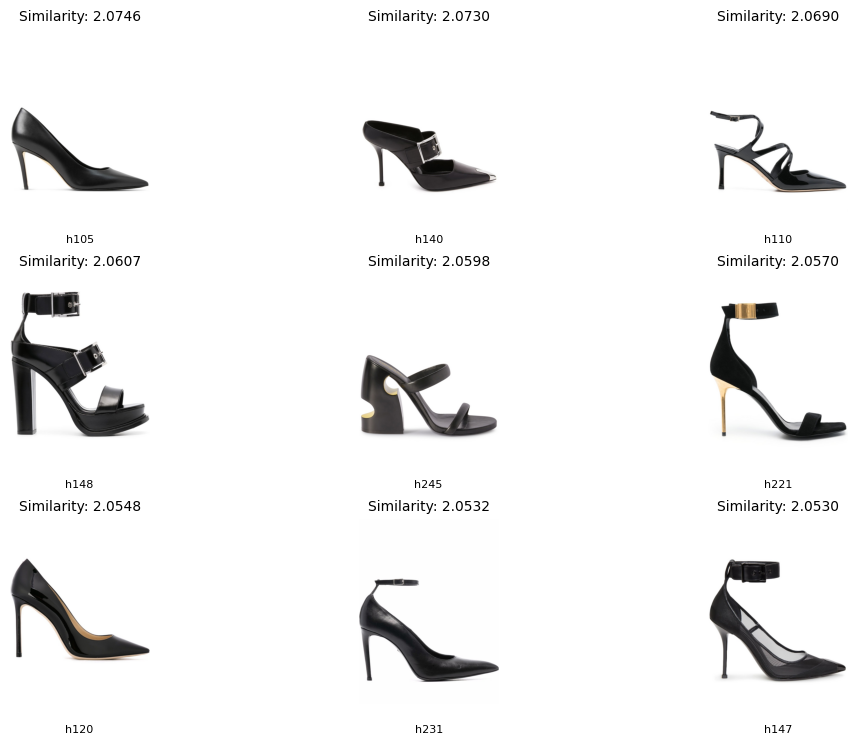

In [19]:
sim_img_dot = sim_for_2_embs_dot(emb1, emb2, category=None, k=9)
plot_similar_images_for_file_and_text(sim_img_dot)

# ______

In [20]:
img1 = 'h105'
text1 = 'black'
emb1 = emb_for_file_and_text(img1, text1)

In [21]:
img2 = 'h149'
emb2 = emb_for_img(img2)

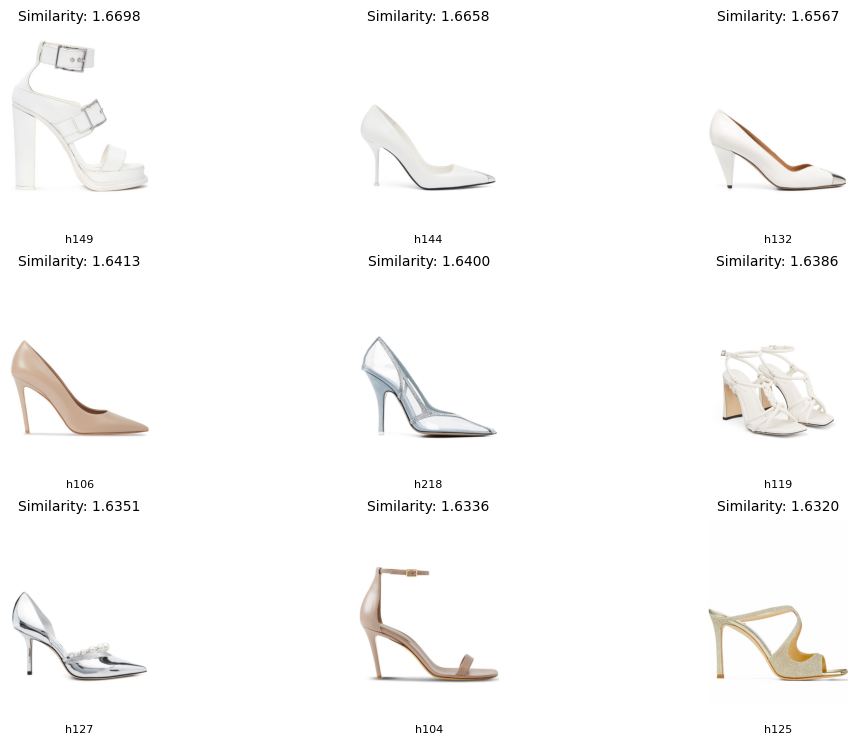

In [22]:
sim_img_dot = sim_for_2_embs_dot(emb1, emb2, category=None, k=9)
plot_similar_images_for_file_and_text(sim_img_dot)

# ___________

In [23]:
img2 = 'h145'
emb2 = emb_for_img(img2)

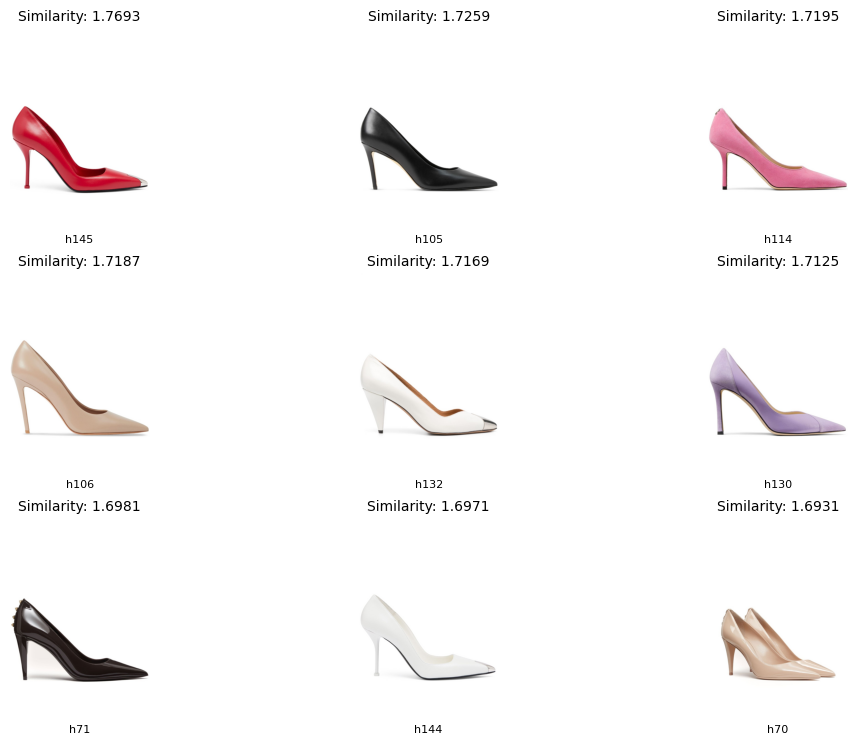

In [24]:
sim_img_dot = sim_for_2_embs_dot(emb1, emb2, category=None, k=9)
plot_similar_images_for_file_and_text(sim_img_dot)

# ___________

In [25]:
img2 = 'd43'
emb2 = emb_for_img(img2)

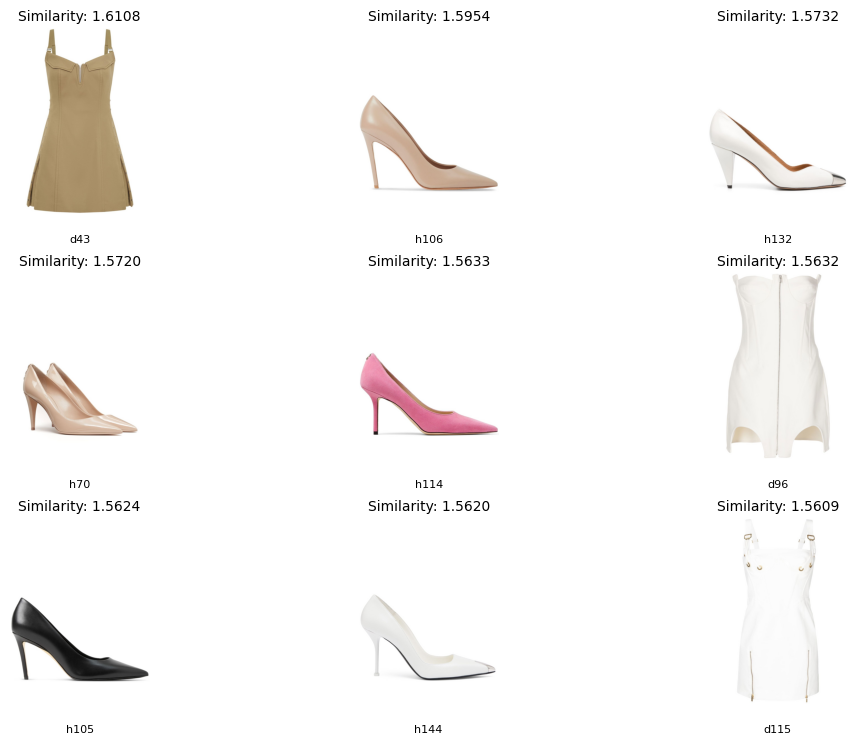

In [26]:
sim_img_dot = sim_for_2_embs_dot(emb1, emb2, category=None, k=9)
plot_similar_images_for_file_and_text(sim_img_dot)

# ___________

In [27]:
img2 = 'd120'
emb2 = emb_for_img(img2)

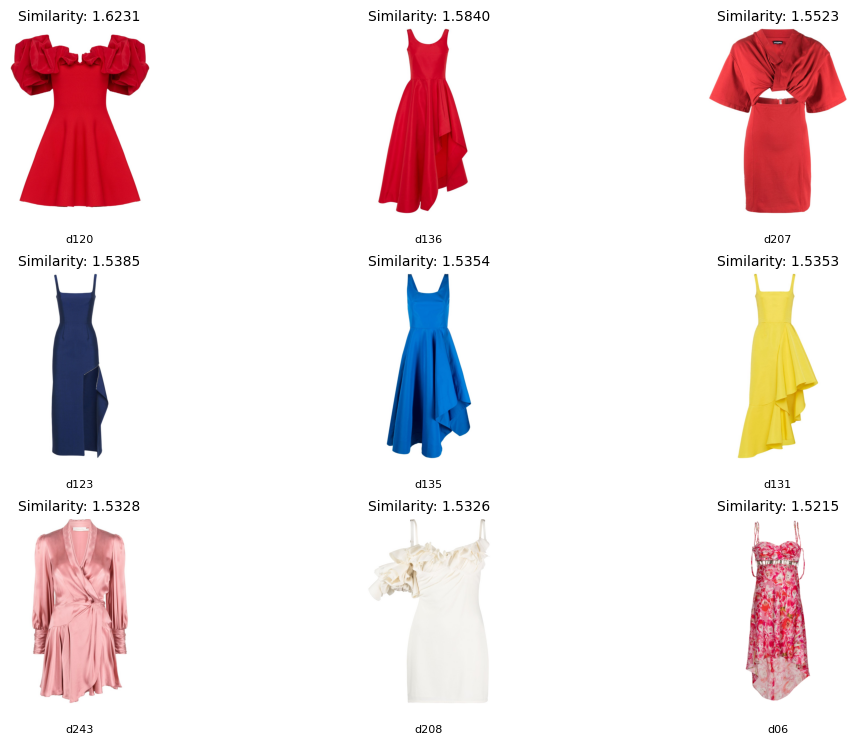

In [28]:
sim_img_dot = sim_for_2_embs_dot(emb1, emb2, category="dress", k=9)
plot_similar_images_for_file_and_text(sim_img_dot)

# ___________

In [29]:
img2 = 'd243'
emb2 = emb_for_img(img2)

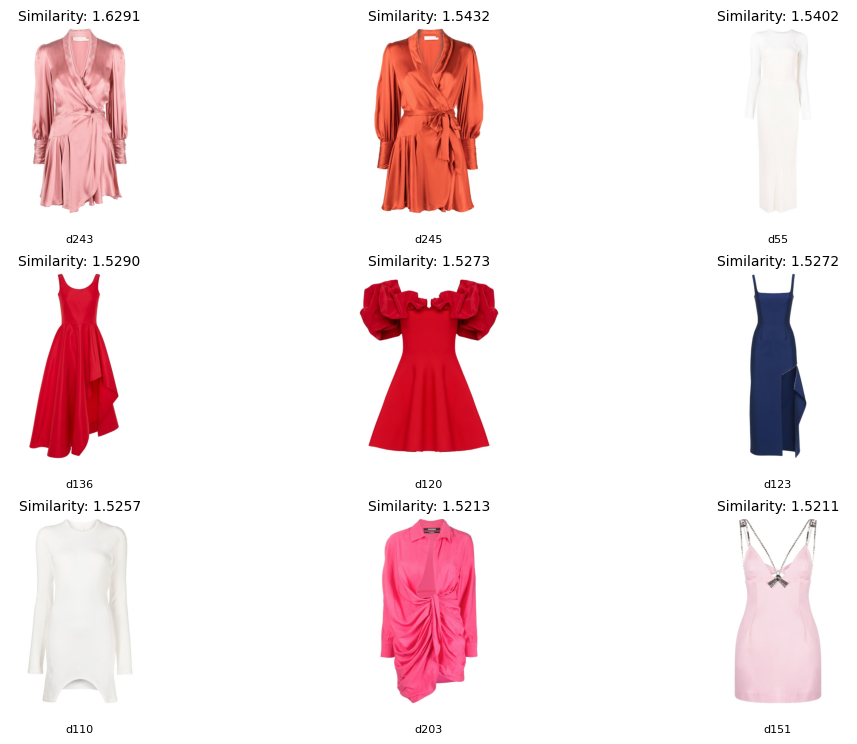

In [30]:
sim_img_dot = sim_for_2_embs_dot(emb1, emb2, category="dress", k=9)
plot_similar_images_for_file_and_text(sim_img_dot)

# ___________

In [31]:
img2 = 'd208'
emb2 = emb_for_img(img2)

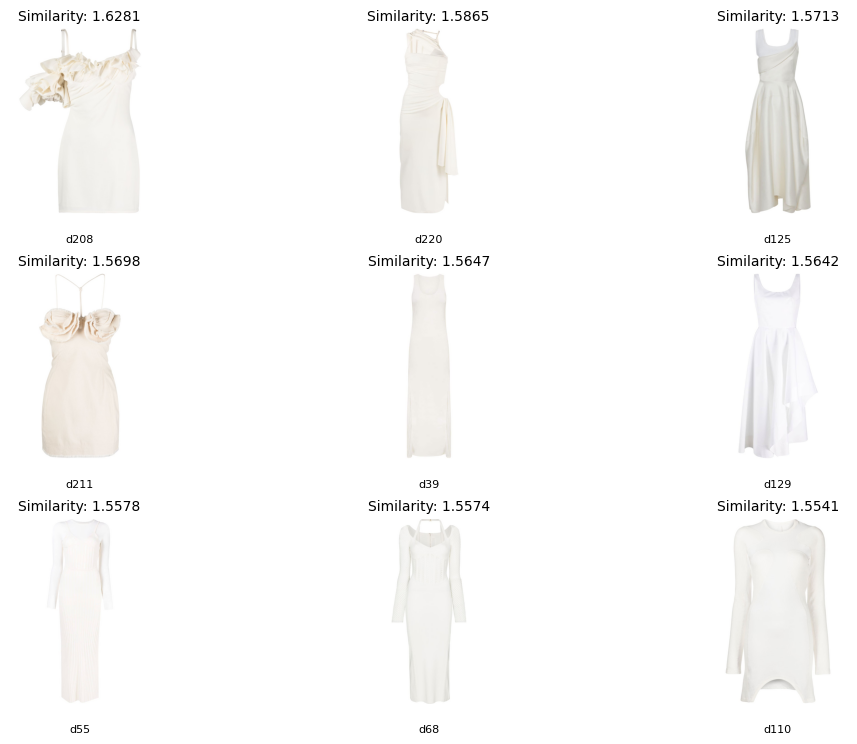

In [32]:
sim_img_dot = sim_for_2_embs_dot(emb1, emb2, category="dress", k=9)
plot_similar_images_for_file_and_text(sim_img_dot)

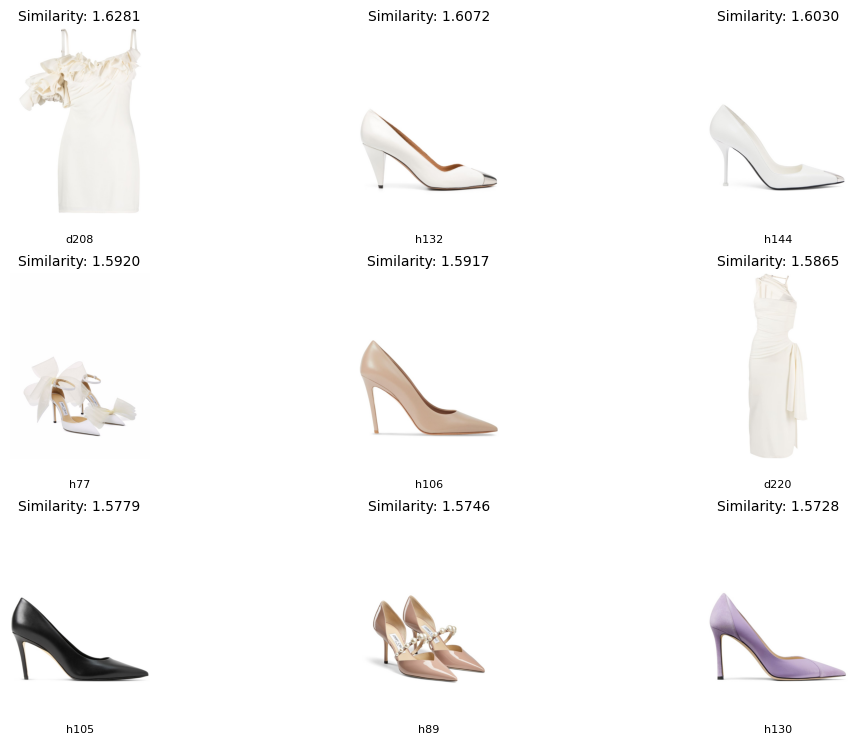

In [33]:
sim_img_dot = sim_for_2_embs_dot(emb1, emb2, category=None, k=9)
plot_similar_images_for_file_and_text(sim_img_dot)

# ___________

In [34]:
img2 = 'd110'
emb2 = emb_for_img(img2)

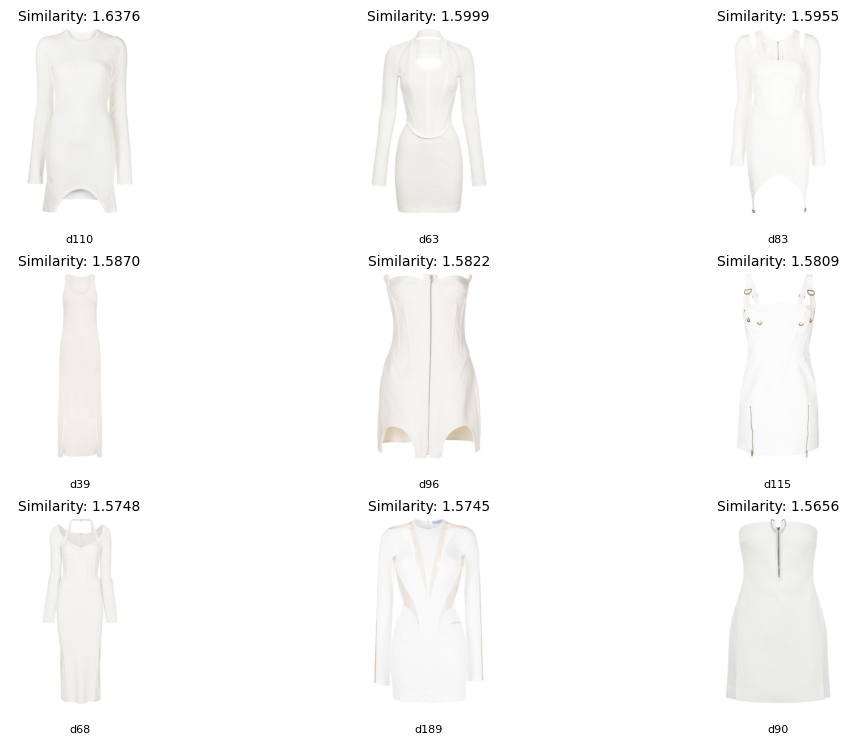

In [35]:
sim_img_dot = sim_for_2_embs_dot(emb1, emb2, category="dress", k=9)
plot_similar_images_for_file_and_text(sim_img_dot)

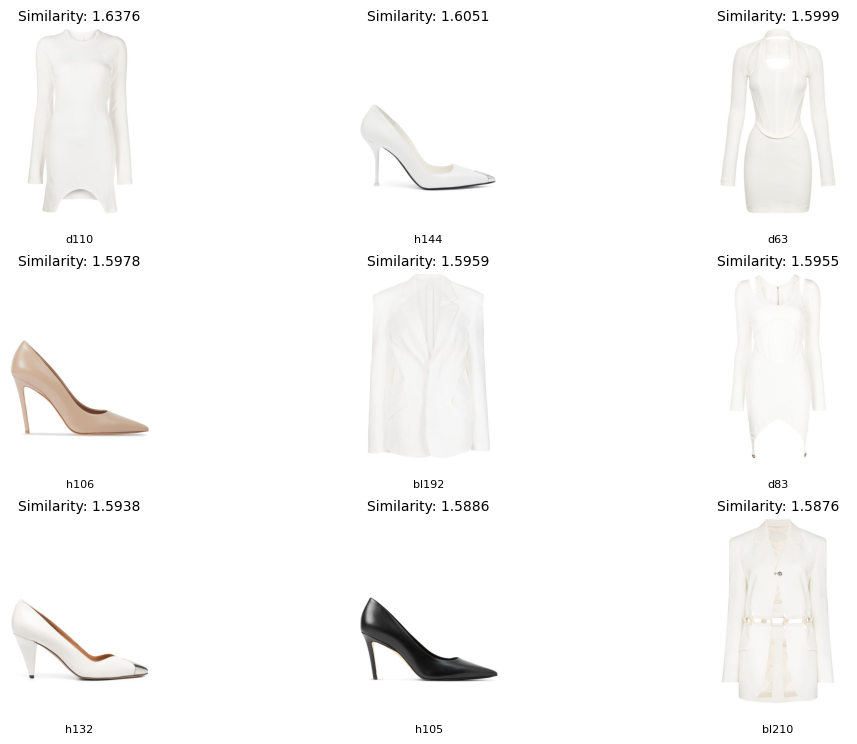

In [36]:
sim_img_dot = sim_for_2_embs_dot(emb1, emb2, category=None, k=9)
plot_similar_images_for_file_and_text(sim_img_dot)